# Simulate Prosumers in a Net-Metered Grid Connected Market 

## Description:
Prosumers are collected as a model with the consumption, generation, net energy and pricing data avaialble. The prosumer data has been built based on Tier1 installations for the purposes of modeling a typical prosumer. The limits on the capacity for Teir1 are also considered. In this simulation parameters for the gross power ratings, AC/DC conversion, will be considered as well as the generation limits. 

**What is Net-Metering?**
[Net metering](https://en.wikipedia.org/wiki/Net_metering) is an electricity billing mechanism that allows consumers who generate some or all of their own electricity to use that electricity anytime, instead of when it is generated. This is particularly important with renewable energy sources like wind and solar. We can define the payment for a prosumer in the state of Florida by the retail pricing provided to the prosumer for every kWh that is injected back into the Grid. 

Considerations when Net-Metering in FPL territory ([FPL Net Metering Guidelines](https://www.fpl.com/clean-energy/net-metering/guidelines.html)):

1. The gross power rating or the alternating current (AC) rating for the system is the array direct current (DC) rating multiplied by 0.85. The AC rating determines the tier that the system falls under for agreement purposes. There are three tiers by system size; tier 1 is 10 kW and below, tier 2 is above 10 kW up to 100 kW, and tier 3 is above 100 kW up to 2,000 kW (2 megawatts).

2. Customer-owned renewable generation shall include a utility-interactive inverter, or other device certified pursuant to FPL’s net-metering agreement, that performs the function of automatically isolating the customer-owned generation equipment from the energy grid in the event of a grid outage. This requirement is necessary to prevent dangerous back feed, which can endanger restoration personnel who may be working to restore the grid. 

3. Customer generation is limited to 90 percent of the FPL service capacity. FPL will upsize facilities for customer generation at the customer’s expense. FPL will not increase the size of the distribution equipment greater than required for a renewable energy system designed to offset all of the customer's annual energy use.


## Steps:
### 1. Data Gathering 
    - Pull in the data from locally built dataset
    - Define payment method and generate profit/expense values
    - Pay prosumers for excess energy generated 
    - Charge prosumers for excess energy consumed

### 2. Analysis of Performance
    - Totals for each prosumer
    - Market view

### 3. Summary and Further Analysis
    - What results shown?
    - Next steps

In [19]:
#import data from sources
import pandas as pd
from functools import reduce
import requests 
import os
import pathlib
from datetime import datetime
import matplotlib.pyplot as plt
from numpy import random
from tabulate import tabulate
import math

# Step 1 : Data Gathering
## 1.1 Collecting Data From Local Dataset
The prosumer data has been built into a Comma-Sperated file that can be parsed with the following format:

| time                |   demand |   generation |   consumption |   net_energy |   price | id      |
|---------------------|----------|--------------|---------------|--------------|---------|---------|
| 2020-11-01 00:00:00 |  621.143 |     1115.12  |        0      |    -493.98   |   12    | 1
| 2020-10-01 00:00:00 | 1110.06  |     1178.87  |        0      |     -68.8135 |   11.49 | 1
| 2020-09-01 00:00:00 | 1226.16  |     1026.59  |      199.568  |       0      |   11.97 | 1
| 2020-08-01 00:00:00 | 1002.64  |      972.796 |       29.8479 |       0      |   11.61 | 1
...(continued)

Parsing the dataset by the 'id' col. allows us to collect individual prosumer data. The next step is to 
put the prosumer data into an object class that contains some of the functionality we will perform on the 
data.

In [63]:
#Import the data to local csv
all_prosumers_data = pd.read_csv('data/prosumer_N3_model_20210129_1416.csv') 
all_prosumers_data["time"] = pd.to_datetime(all_prosumers_data['time'], format='%Y-%m-%d %H:%M')
all_prosumers_data.sort_values(by='time')
prosumer_data = [pd.DataFrame(y) for x, y in all_prosumers_data.groupby('id', as_index=False)]

#print(prosumer_data[0]) #show the first prosumer in the dataset
print(all_prosumers_data)

         time       demand   generation  consumption  net_energy  price  id
0  2020-11-01   713.636892  1001.611236     0.000000 -287.974344  12.00   1
1  2020-10-01  1033.715254  1124.283176     0.000000  -90.567922  11.49   1
2  2020-09-01  1169.504690  1200.000000     0.000000  -30.495310  11.97   1
3  2020-08-01   745.056436  1118.585765     0.000000 -373.529328  11.61   1
4  2020-07-01  1088.967130  1075.337671    13.629459    0.000000  11.71   1
5  2020-06-01  1202.880127   979.940026   222.940101    0.000000  11.53   1
6  2020-05-01   839.217153   945.914118     0.000000 -106.696964   9.84   1
7  2020-04-01   726.229347  1042.016842     0.000000 -315.787495  11.71   1
8  2020-03-01  1136.909963   767.108299   369.801664    0.000000  11.64   1
9  2020-02-01   405.862473   787.888820     0.000000 -382.026347  11.76   1
10 2020-01-01   666.182080   788.227717     0.000000 -122.045637  11.73   1
11 2019-12-01   785.346708   491.636087   293.710621    0.000000  11.62   1
12 2019-11-0

## 1.2 Define the Prosumer Object
To transform the data we will collect it as an object with functions for use in the simulation.  

In [48]:
class Prosumer:
    def __init__(self,data, cost_of_energy):
        self.id = data['id'].iloc[0]
        self.data = data #time,demand,generation,consumption,net_energy,price,id
        # Calculate the profit given the price and net energy
        self.data['profit'] = cost_of_energy(net_energy=self.data['net_energy'],price=self.data['price'])
        # Calculate the expense given the price and net energy
        self.data['expense'] = cost_of_energy(net_energy=self.data['consumption'],price=self.data['price'])
    def get_total_profit(self):
        return self.data['profit'].sum()
    def get_total_expense(self):
        return self.data['expense'].sum()
    def table(self):
        print(tabulate(self.data, headers = 'keys', tablefmt = 'github',showindex=False))
    def plot_energy(self):
        # plot all curve associated with prosumer
        self.data.plot(x='time',y=['demand','generation','consumption','net_energy'],title=f"Energy - Prosumer:{self.id}")
        plt.show()
    def plot_ledger(self):
        # plot all curve associated with prosumer
        self.data.plot(x='time',y=['expense','profit'],title=f"Energy - Ledger - Prosumer:{self.id}")
        plt.show()

## 1.3 Define the Cost of Energy Method
To generate the payment and profit needed we need to utilize the net meter payment method. The retail price of electricity will be used to pay the customer for excess energy. It will also be the method to charge the customer for any energy consumed. 

In [49]:
def cost_of_energy(price,net_energy):
    # convert to dollars from cents
    return abs(net_energy)*(0.01*price)

## 1.4 Update each prosumer with Profit/Expense data
Each prosumer will have to draw energy from the grid. When it does it will incurr an expense for that energy at the retail rate for electricity. 

In [50]:
# Generate prosumers based on normalized curves from data gethering stage
prosumers = []
for data in prosumer_data:
    prosumers.append(Prosumer(data,cost_of_energy))

# number of prosumers retrieved from dataset
N = len(prosumers)

# Step 2: Analysis of Performance
## 2.1 Analyze the Performance by Prosumer
Each prosumer will consume energy and pay retail price for it. At the same time each prosumer will get paid for the generated net energy at the reail price. This allows us to look at the revenue for each prosumer given its individual performance. The result shows the demand for energy during the winter months. The simulation coincides with experimental assumptions of the data. The winter season would yield the lowest net generation and the greatest consumption of energy. 



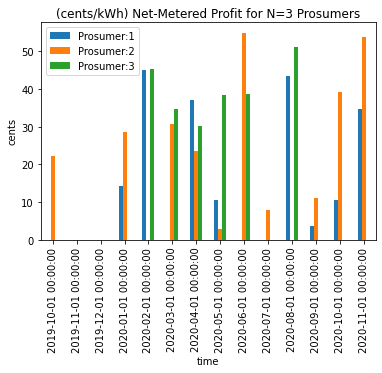

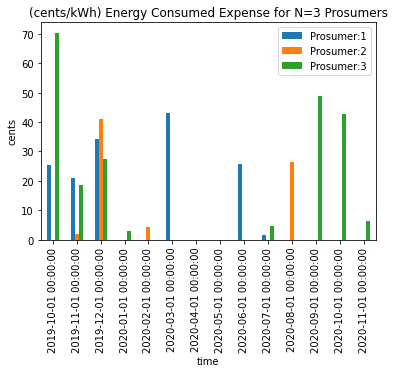

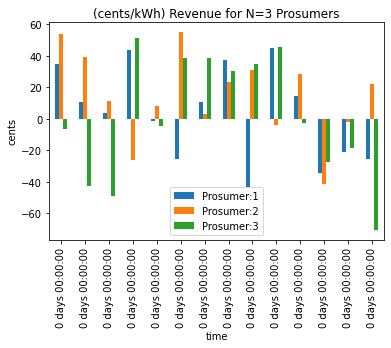

In [75]:
def get_curve_accross_prosumers(type_name):
    prosumers_arr = []
    for prosumer in prosumers:
        prosumers_arr.append(
            pd.DataFrame(list(zip(prosumer.data['time'],prosumer.data[type_name])),
            columns=['time',f'Prosumer:{prosumer.id}']))
    return reduce(lambda left,right: pd.merge(left,right,on=['time'],how='outer'), prosumers_arr)
    
#show pricing for all prosumers
all_profits = get_curve_accross_prosumers('profit')
all_expenses = get_curve_accross_prosumers('expense')
all_revenue = all_profits - all_expenses

ax = all_profits.sort_values(by='time').plot.bar(x='time',title=f"(cents/kWh) Net-Metered Profit for N={len(prosumers)} Prosumers")
ax.set_ylabel("cents")
ax = all_expenses.sort_values(by='time').plot.bar(x='time',title=f"(cents/kWh) Energy Consumed Expense for N={len(prosumers)} Prosumers")
ax.set_ylabel("cents")
ax = all_revenue.sort_values(by='time').plot.bar(x='time',title=f"(cents/kWh) Revenue for N={len(prosumers)} Prosumers")
ax.set_ylabel("cents")
#plt.legend('')
plt.show()




## 2.2 Analysis of the Market Performance
The total market performance can include the following players:

1. Utility (Grid Owner)
2. Prosumer
3. Consumer

Where the Grid Owner, is considered the Utility company providing the power to the consumers and prosumers. When there is a prosumer that does not generate any net energy it would be considered a consumer for that period. When a consumer purchases power to meet its demand the total consumption would come directly from the Utility. 

### Utility Market Diagram
![Prosumer-Utility-Market-Diagram](img/prosumer_utility_market.png)

In [105]:
print("\nProfit Table")
print(tabulate(all_profits,headers='keys',tablefmt = 'github',showindex=False))
print("\nTotal Profits")
print(f"{all_profits.sum()}")

print("\nExpense Table")
print(tabulate(all_expenses,headers='keys',tablefmt = 'github',showindex=False))
print("\nTotal Expenses")
print(f"{all_expenses.sum()}")

print("\nRevenue Table")
print(tabulate(all_revenue,headers='keys',tablefmt = 'github',showindex=False))
print("\nTotal Revenues")
print(f"{all_revenue.sum()[1:]}")




Profit Table
| time                |   Prosumer:1 |   Prosumer:2 |   Prosumer:3 |
|---------------------|--------------|--------------|--------------|
| 2020-11-01 00:00:00 |     34.5569  |     53.821   |       0      |
| 2020-10-01 00:00:00 |     10.4063  |     39.0498  |       0      |
| 2020-09-01 00:00:00 |      3.65029 |     11.0422  |       0      |
| 2020-08-01 00:00:00 |     43.3668  |      0       |      51.0655 |
| 2020-07-01 00:00:00 |      0       |      7.90852 |       0      |
| 2020-06-01 00:00:00 |      0       |     54.929   |      38.6809 |
| 2020-05-01 00:00:00 |     10.499   |      2.85888 |      38.4321 |
| 2020-04-01 00:00:00 |     36.9787  |     23.5928  |      30.1827 |
| 2020-03-01 00:00:00 |      0       |     30.6748  |      34.5882 |
| 2020-02-01 00:00:00 |     44.9263  |      0       |      45.2307 |
| 2020-01-01 00:00:00 |     14.316   |     28.4651  |       0      |
| 2019-12-01 00:00:00 |      0       |      0       |       0      |
| 2019-11-01 00:00:0

## 2.3 Analysis of the Market Performance for 100 Prosumers
To understand the scalability of the market, we will simulate N=100 prosumers. The charts will show the same volatility curves and calcualte the revenue, from the profit and expenses during the demand and generation curves.

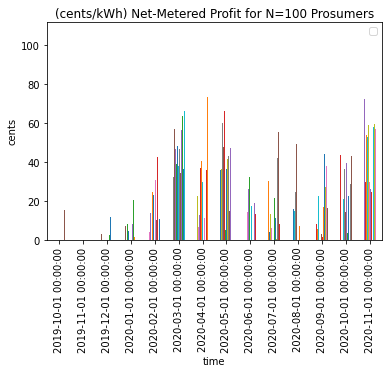

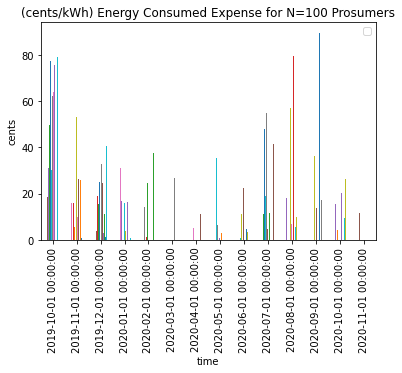

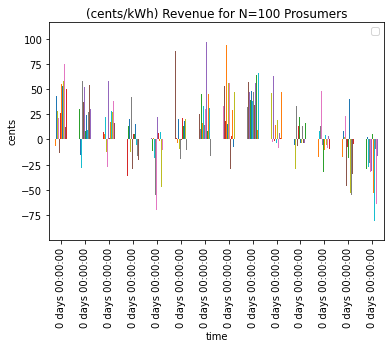

88726 |       1.34621 |      22.8408  |    -13.627    |       3.97068 |     -40.8242  |       9.25057 |     12.7042   |      4.45753  |      16.8396  |    -35.9198   |      38.5574  |     -20.4981  |      -30.7345 |       2.85739 |      55.3607  |     59.4784   |       28.1975 |      43.8702  |      13.0949  |      0.410154 |     -0.324381 |     -25.7665  |      26.5099  |      4.17788  |     -38.2941  |    27.3436    |      15.0823  |     -89.7591  |      21.0155  |      10.0136  |    -12.6127   |      24.2034  |       9.21508 |      37.8328  |     80.5501   |      16.6552  |    -37.5172   |     13.6054   |    -20.8893   |      29.9694  |     -37.4974  |      23.3019  |      16.46    |      -19.3135 |     -17.2139  |     -10.2212  |     29.1397    |
| 0 days 00:00:00 |   -27.1936   |    58.9018   |    -62.5314  |    -36.114   |   -17.929    |     31.8324  |    -22.844   |    -13.855   |    -12.39    |       6.05188 |      16.0271  |      21.5965  |      13.0608  |     -37.2104  |     

In [109]:
#Import the data to local csv
all_prosumers_data = pd.read_csv('data/prosumer_N100_model_20210129_1414.csv') 
all_prosumers_data["time"] = pd.to_datetime(all_prosumers_data['time'], format='%Y-%m-%d %H:%M')
all_prosumers_data.sort_values(by='time')
prosumer_data = [pd.DataFrame(y) for x, y in all_prosumers_data.groupby('id', as_index=False)]
# Generate prosumers based on normalized curves from data gethering stage
prosumers = []
for data in prosumer_data:
    prosumers.append(Prosumer(data,cost_of_energy))

# number of prosumers retrieved from dataset
N = len(prosumers)
def get_curve_accross_prosumers(type_name):
    prosumers_arr = []
    for prosumer in prosumers:
        prosumers_arr.append(
            pd.DataFrame(list(zip(prosumer.data['time'],prosumer.data[type_name])),
            columns=['time',f'Prosumer:{prosumer.id}']))
    return reduce(lambda left,right: pd.merge(left,right,on=['time'],how='outer'), prosumers_arr)
    
#show pricing for all prosumers
all_profits = get_curve_accross_prosumers('profit')
all_expenses = get_curve_accross_prosumers('expense')
all_revenue = all_profits - all_expenses

ax = all_profits.sort_values(by='time').plot.bar(x='time',title=f"(cents/kWh) Net-Metered Profit for N={len(prosumers)} Prosumers")
ax.set_ylabel("cents")
ax.legend('')
ax = all_expenses.sort_values(by='time').plot.bar(x='time',title=f"(cents/kWh) Energy Consumed Expense for N={len(prosumers)} Prosumers")
ax.set_ylabel("cents")
ax.legend('')
ax = all_revenue.sort_values(by='time').plot.bar(x='time',title=f"(cents/kWh) Revenue for N={len(prosumers)} Prosumers")
ax.set_ylabel("cents")
ax.legend('')
plt.show()

print("\nProfit Table")
print(tabulate(all_profits,headers='keys',tablefmt = 'github',showindex=False))
print("\nTotal Profits")
print(f"{all_profits.sum()}")

print("\nExpense Table")
print(tabulate(all_expenses,headers='keys',tablefmt = 'github',showindex=False))
print("\nTotal Expenses")
print(f"{all_expenses.sum()}")

print("\nRevenue Table")
print(tabulate(all_revenue,headers='keys',tablefmt = 'github',showindex=False))
print("\nTotal Revenues")
print(f"{all_revenue.sum()[1:]}")


# Step 3: Summary and Further Studies

The total revenue of each prosumer was positive during the simulation. The variability in generation is a key factor in sustained profit to offset the consumption. The retail price per month coincides with the times the utility is expecting the greatest demand. The dynamic pricing results in adjustments to the load expected by the utility. The solar generation covered the load of the homes but would of been even greater if the capacity of the homes generatin units was not limited by the utility. Further analysis should be taken to validate the performance of Tier2/Tier3 systems during the same demand curves. These larger systems should produce more and provide greater revenue. 

The cost to transfer power from the utility to the prosumers is embedded in the reail cost of electric consumption. When the prosumers offset the generation they end up getting money back and not paying for the operating maitenance of the distribution of power. This cost is most times injected into the consumers retail price of electricity. Much regulation is pursued by utilities to offset this dynamic. A further analysis would be to understand how much energy is owed in distribution costs and if it can still be offset by the annual revenue from generation of the prosumers.

## Time of Use vs Flat Rate
In this simulation we considered TOU time of use rates for consumption to be equal to the retail electricity rates. In the FPL territory a typical residential home is opted into a flat rate. The flat rate would be fixed for up to a 1000kWh/mo. The fixed rate for the years the simulation was running should be used and the returns should then be considered when analyzing the revenue for the prosumers.

[Residential Rates for Consumption](https://www.fpl.com/content/dam/fpl/us/en/rates/pdf/Residential%20(Effective%20January%202021).pdf)